All imports


In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import random
import time
from torchsummary import summary

c:\Users\Ehaan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\Ehaan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Data download

In [ ]:
# Define transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the pixel values to be in range [-1, 1]
])

# Download and load the training set
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test set
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
def get_images_labels(dataset):
    '''
    Function for getting an instance of the image and label for all 10 different digits
    'dataset' can be the test or trainset
    '''
    digits_xy = {digit: None for digit in range(10)}
    # dataset
    for i in range(10):
        indices = (dataset.targets == i).nonzero().view(-1)
        rand_index = random.randrange(indices.size(dim=0))
        digits_xy[i] = dataset[indices[rand_index]][0].squeeze()
    return digits_xy


def show_images(digits):
    # a figure with 2 rows and 5 columns
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))

    axs = axs.flatten()

    for index, (digit, image) in enumerate(digits.items()):
        axs[index].imshow(image.squeeze().detach().numpy(), cmap='gray')
        axs[index].set_title(f'Digit: {digit}')
        axs[index].axis('off')

    # adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

def get_adv_targets(digits):
    return {k : (v, [i for i in range(10) if i!=k]) for k, v in digits.items()}

In [ ]:
def get_adv_example_3(image, flow_field):
    '''
    'image' is the unperturbed image tensor with shape [H=28, W=28]
    'flow_field' is the flowfield used to obtain x_adv from x, f has shape [H=28, W=28, 2]
    returns x_adv with shape [H=28, W=28]
    '''
    H, W = image.size(0), image.size(1)

    # Generate grid of indices for interpolation
    grid_h, grid_w = torch.meshgrid(torch.arange(H), torch.arange(W))
    grid_h = grid_h.float()
    grid_w = grid_w.float()

    # Add flow field to grid indices
    u = grid_h + flow_field[..., 0]
    v = grid_w + flow_field[..., 1]

    # Ensure indices are within bounds
    u = torch.clamp(u, 0, H - 1)
    v = torch.clamp(v, 0, W - 1)

    # Indices for top-left, top-right, bottom-left, bottom-right pixels
    h0 = u.floor().long()
    w0 = v.floor().long()
    h1 = h0 + 1
    w1 = w0 + 1

    # Bilinear interpolation weights
    fu = u - h0.float()
    fv = v - w0.float()

    # Ensure indices are within bounds
    h0 = torch.clamp(h0, 0, H - 1)
    h1 = torch.clamp(h1, 0, H - 1)
    w0 = torch.clamp(w0, 0, W - 1)
    w1 = torch.clamp(w1, 0, W - 1)

    # Interpolate
    top_left = image[h0, w0]
    top_right = image[h0, w1]
    bottom_left = image[h1, w0]
    bottom_right = image[h1, w1]

    top_interp = (1 - fu) * top_left + fu * top_right
    bottom_interp = (1 - fu) * bottom_left + fu * bottom_right

    interpolated_value = (1 - fv) * top_interp + fv * bottom_interp

    return interpolated_value

def L_flow_2(flow_field):
    delta_u = flow_field[:, :, 0]
    delta_v = flow_field[:, :, 1]

    # Pad the deltas to handle the borders (assumes zero padding)
    delta_u_padded = F.pad(delta_u, pad=(1, 1, 1, 1), mode='constant', value=0)
    delta_v_padded = F.pad(delta_v, pad=(1, 1, 1, 1), mode='constant', value=0)

    # Calculate differences between adjacent pixels (up, down, left, right)
    diff_u_up = delta_u_padded[2:, 1:-1] - delta_u_padded[1:-1, 1:-1]
    diff_u_down = delta_u_padded[:-2, 1:-1] - delta_u_padded[1:-1, 1:-1]
    diff_v_left = delta_v_padded[1:-1, 2:] - delta_v_padded[1:-1, 1:-1]
    diff_v_right = delta_v_padded[1:-1, :-2] - delta_v_padded[1:-1, 1:-1]

    # Compute L2 norms for each direction and sum them up
    L_flow = torch.sum(torch.sqrt(diff_u_up**2 + diff_v_left**2 + 1e-8)) + torch.sum(torch.sqrt(diff_u_down**2 + diff_v_right**2 + 1e-8))
    # print(f'L_flow output has the following shape = {L_flow.size()}')
    return L_flow

In [ ]:
def closure_factory(x, flow_field, model, t, tau, kappa, optimizer):
    """
    A factory function that creates and returns a closure function with the right image x,
    an inititial flow_field to optimize, a model and target tfor optimization.

    Parameters:
    - x: the unperturbed image tensor.
    - flow_field: the flow field tensor with requires_grad=True.
    - model: the trained neural network model to use for generating adversarial examples.
    - t: the target label, different from the true label of x.

    Returns:
    A closure function suitable for the optimizer.
    """
    def closure():
        # print("...")
        optimizer.zero_grad()
        flow_field.requires_grad_(True)
        #adversarial_example = flow_st(x.unsqueeze(0).unsqueeze(0),flows).squeeze()
        adversarial_example = get_adv_example_3(x, flow_field)
        output = model(adversarial_example.unsqueeze(0).unsqueeze(0))
        # Masking out the value at [0, t]
        masked_output = output.clone()
        masked_output[0, t] = float('-inf')  # Set it to negative infinity or any value that ensures it won't be selected as the maximum
        # Find the maximum value in the masked output
        max_value_excluding_t = torch.max(masked_output)
        # Set the t'th element of the difference tensor to be the original value of output[0, t]
        output_diff = max_value_excluding_t-output[0, t]
        L_adv = torch.max(output_diff, kappa).values
        L_flow = L_flow_2(flow_field)
        loss = L_adv + tau * L_flow
        loss.backward()
        return loss.item()

    return closure
def get_optimized_x_adv(image_x, model, target, num_steps, tau, kappa,
                        lr, max_iter, max_eval,
                        tolerance_grad, tolerance_change,
                        history_size, line_search_fn):
    size = image_x.squeeze().size()
    delta = 1e-15

    flow_field = torch.zeros(*size, 2) + delta
    flow_field.requires_grad_(True)

    optimizer = torch.optim.LBFGS([flow_field], lr=lr, max_iter=max_iter, max_eval=max_eval,
                              tolerance_grad=tolerance_grad, tolerance_change=tolerance_change,
                              history_size=history_size,
                              line_search_fn=line_search_fn)

    closure = closure_factory(image_x, flow_field, model, target, tau, kappa, optimizer)
    for step in range(num_steps):
        try:
          optimizer.step(closure)
        except ValueError as e:
          error_message = str(e)
          print(f"Caught an error: {error_message}")
    return get_adv_example_3(image_x, flow_field)


def show_x_and_x_adv(x, x_adv, t):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(x_adv.squeeze().detach().numpy(), cmap='gray')
    axs[0].set_title(f'Adversarial Example with target t = {t}')
    axs[0].axis('off')
    axs[1].imshow(x, cmap='gray')
    axs[1].set_title('Original Image')
    axs[1].axis('off')
    plt.show()

In [ ]:
testset_with_random_targets = torch.load('testset_with_random_targets.pth')

In [ ]:
Kernel_size = 5
N_channels = 64
P_1 = 0.25
P_2 = 0.5
in_features = 64 * 20 * 20
hidden_size =  128
output_size = 10
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers of the network
        self.Conv1 = nn.Conv2d(1, N_channels, Kernel_size, bias=False)  # Convolutional layer with 1 input channel, 32 output channels, and 3x3 kernel
        self.Conv2 = nn.Conv2d(N_channels, N_channels, Kernel_size, bias=False) # Convolutional layer with 32 input channels, 64 output channels, and 3x3 kernel
        self.Dropout1 = nn.Dropout(p=P_1)
        self.FC1 = nn.Linear(in_features, hidden_size)  # Fully connected layer with 64*6*6 input features and 128 output features
        self.Dropout2 = nn.Dropout(p=P_2)
        self.FC2 = nn.Linear(hidden_size, output_size)      # Fully connected layer with 128 input features and 10 output features (for 10 classes)

    def forward(self, x):
        # A good programmer always debugs using print statements
        # Define the forward pass through the network
        x = F.relu(self.Conv1(x))   # Apply convolution, then ReLU activation
        #print("shape after first conv", x.shape)
        x = F.relu(self.Conv2(x))   # Apply convolution, then ReLU activation
        #print("shape after second conv",x.shape)
        x = self.Dropout1(x)    #Apply dropout
        #print("shape after first dropout",x.shape)
        x = torch.flatten(x, start_dim=1) # Reshape the tensor for the fully connected layer
        #print("shape after flattening",x.shape)
        x = F.relu(self.FC1(x))     # Apply ReLU activation to the first fully connected layer
        #print("shape after first FC",x.shape)
        x = self.Dropout2(x)    #Apply dropout
        #print("shape after second dropout",x.shape)
        x = self.FC2(x)      # Apply the second fully connected layer, then Softmax
        # Apply softmax activation function
        x = F.softmax(x, dim=1)
        #print("shape after second FC",x.shape)
        return x

modelA = Net()
modelA.load_state_dict(torch.load('model_A.pth'))
summary(modelA,(1,28,28))

#Load model B
modelB = nn.Sequential(
    nn.Conv2d(1,64,8),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Conv2d(64,128,6),
    nn.ReLU(),
    nn.Conv2d(128,128,5),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Flatten(start_dim=1),
    nn.Linear(18432,10),
    nn.Softmax(dim=1)
)

modelB.load_state_dict(torch.load('model_B.pth'))
summary(modelB,(1,28,28))

# Model C [table 4] trained on MNIST dataset
class ModelC(nn.Module):

    # Specify layers
    def __init__(self):
        super(ModelC, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, 3) # mnist has single channel input
        self.conv2 = nn.Conv2d(128, 64, 3)
        self.drop1 = nn.Dropout(0.25)
        self.fc1   = nn.Linear(64*24*24, 128)
        self.drop2 = nn.Dropout(0.50)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # Conv(128, 3, 3) + Relu
        x = F.relu(self.conv2(x)) # Conv(64, 3, 3) + Relu
        x = self.drop1(x)         # Dropout(0.25)
        x = torch.flatten(x, 1)   # Flatten
        x = F.relu(self.fc1(x))   # FC(128) + Relu
        x = self.drop2(x)         # Dropout(0.50)
        x = F.relu(self.fc2(x))   # FC(10)
        return F.log_softmax(x, dim=1) # + Softmax
modelC = ModelC()
modelC.load_state_dict(torch.load('model_C.pth'))
summary(modelC,(1,28,28))

class NetZ(nn.Module):
  def __init__(self):
    super(NetZ, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 32, 3, 1)
    self.conv3= nn.Conv2d(32, 64, 3, 1)
    self.conv4= nn.Conv2d(64, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(1024, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout1(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

modelZ = NetZ()
modelZ.load_state_dict(torch.load('model_Z.pth', map_location=torch.device('cpu')))
summary(modelZ,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 24, 24]          1,600
├─Conv2d: 1-2                            [-1, 64, 20, 20]          102,400
├─Dropout: 1-3                           [-1, 64, 20, 20]          --
├─Linear: 1-4                            [-1, 128]                 3,276,928
├─Dropout: 1-5                           [-1, 128]                 --
├─Linear: 1-6                            [-1, 10]                  1,290
Total params: 3,382,218
Trainable params: 3,382,218
Non-trainable params: 0
Total mult-adds (M): 45.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 12.90
Estimated Total Size (MB): 13.38
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 21, 21]          4,160
├─ReLU: 1-2                              [-1, 64, 21, 21]          --
├─Dropout: 1-3                           [-1, 64,

c:\Users\Ehaan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 26, 26]          320
├─Conv2d: 1-2                            [-1, 32, 24, 24]          9,248
├─Conv2d: 1-3                            [-1, 64, 10, 10]          18,496
├─Conv2d: 1-4                            [-1, 64, 8, 8]            36,928
├─Linear: 1-5                            [-1, 200]                 205,000
├─Dropout2d: 1-6                         [-1, 200]                 --
├─Linear: 1-7                            [-1, 200]                 40,200
├─Linear: 1-8                            [-1, 10]                  2,010
Total params: 312,202
Trainable params: 312,202
Non-trainable params: 0
Total mult-adds (M): 9.95
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 1.19
Estimated Total Size (MB): 1.58

In [ ]:
def generate_adv_test_get(testset_with_random_targets, model, start, end_exclusive, model_letter):
    """
    - using default values for num_steps in get_optimized_x_adv function which is 5
    """
    # To generate different versions of the adversarial dataset, we can change the hyperparameters in the get_optimized_x_adv function called below
    print(f'=============================== FINDING ADVERSARIAL EXAMPLES FOR MODEL {model_letter} =======================')
    ret = []
    counter = start
    for sample, label, target in testset_with_random_targets[start:end_exclusive]:
        # print(f'now finding x_adv for {counter} / {end_exclusive}')
        adv_example = None
        while adv_example is None:
            adv_example = get_optimized_x_adv(sample, model, target,
                                              num_steps= 50, tau=0.05, kappa=0, lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-15,
                                              tolerance_change=1e-15, history_size=100, line_search_fn="strong_wolfe")
        print(f'found x_adv for {counter} / {end_exclusive}')
        output = model(sample.unsqueeze(0).unsqueeze(0)).topk(1, dim=1).indices[0][0].item()
        adv_output = model(adv_example.unsqueeze(0).unsqueeze(0)).topk(1, dim=1).indices[0][0].item()
        ret.append((sample, label, target, adv_example, output, adv_output))
        counter += 1

    torch.save(ret, f'adv_test_set_model{model_letter}_{start}_{end_exclusive}.pth')
    return ret

    # return [(sample, label, target, get_optimized_x_adv(sample, model, target,
    # num_steps= 5, tau=0.05, kappa=0, lr=1, max_iter=1000, max_eval=None, tolerance_grad=1e-10, tolerance_change=1e-10, history_size=100, line_search_fn="strong_wolfe")) for sample, label, target in testset_with_random_targets]


def save_statistics(list_of_tuples, name_of_file):
    # (0: sample, 1:label, 2:target, 3:adv_example, 4:output, 5:adv_output)
    correct_normal = sum(1 for z in list_of_tuples if z[1] == z[4])
    correct_targeted = sum(1 for z in list_of_tuples if z[2] == z[5])
    correct_untargeted = sum(1 for z in list_of_tuples if z[1] != z[5])
    print(f'performance accuracy: {correct_normal/len(list_of_tuples)}')
    print(f'attack success rate targeted: {correct_targeted/len(list_of_tuples)}')
    print(f'attack success rate untargeted: {correct_untargeted/len(list_of_tuples)}')
    torch.save([(correct_normal, correct_targeted, correct_untargeted)], f'{name_of_file}.pth')

num_samples = 1000
### A
start_time = time.time()
adv_test_set_A = generate_adv_test_get(testset_with_random_targets, modelA, 0, num_samples, 'A')
save_statistics(adv_test_set_A, "adv_test_set_A_results_0_10000")
end_time = time.time()
duration = end_time - start_time
hours = duration // 3600
minutes = (duration % 3600) // 60
seconds = duration % 60
print(f"Duration: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")
# ### B
# start_time = time.time()
# adv_test_set_A = generate_adv_test_get(testset_with_random_targets, modelB, 0, num_samples, 'B')
# save_statistics(adv_test_set_A, "adv_test_set_B_results_0_10000")
# end_time = time.time()
# duration = end_time - start_time
# hours = duration // 3600
# minutes = (duration % 3600) // 60
# seconds = duration % 60
# print(f"Duration: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")
# ### C
# start_time = time.time()
# adv_test_set_A = generate_adv_test_get(testset_with_random_targets, modelC, 0, num_samples, 'C')
# save_statistics(adv_test_set_A, "adv_test_set_C_results_0_10000")
# end_time = time.time()
# duration = end_time - start_time
# hours = duration // 3600
# minutes = (duration % 3600) // 60
# seconds = duration % 60
# print(f"Duration: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")
# ### Z = model from github
# start_time = time.time()
# adv_test_set_A = generate_adv_test_get(testset_with_random_targets, modelA, 0, num_samples, 'Z')
# save_statistics(adv_test_set_A, "adv_test_set_Z_results_0_10000")
# end_time = time.time()
# duration = end_time - start_time
# hours = duration // 3600
# minutes = (duration % 3600) // 60
# seconds = duration % 60
# print(f"Duration: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

# adv_test_set_B = generate_adv_test_get(testset_with_random_targets, modelB, 0, 1000, 'B')
# adv_test_set_C = generate_adv_test_get(testset_with_random_targets, modelC, 0, 1000, 'C')

In [ ]:
torch.save(adv_test_set_A,"50_steps_1000_samples.pth")

In [ ]:
adv_test_set_A = torch.load("50_steps_1000_samples.pth")

In [ ]:
def plot_tensor(tensor):
    # Convert tensor to numpy array
    tensor_np = tensor.detach().cpu().numpy()  # Ensure it's detached from any computational graph and on CPU

    # Plot the tensor
    plt.imshow(tensor_np, cmap='gray')  # Assuming grayscale image, adjust colormap as needed
    plt.axis('off')
    plt.show()

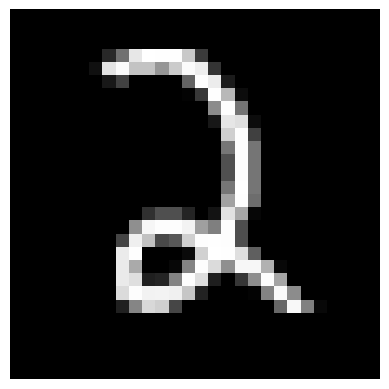

original number: 2
adversarial target: 0


In [ ]:
random_integer = random.randint(0, 999)
plot_tensor(adv_test_set_A[random_integer][3])
print(f"original number: {adv_test_set_A[random_integer][1]}")
print(f"adversarial target: {adv_test_set_A[random_integer][2]}")